In [30]:
import shutup
import torch
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tsgcn.simulation import MsprimeSimulation, run_sims
from tsgcn.util import get_idle_gpu
from tsgcn.data import TreeSequenceData, TreeSequencesDataset, windowed_div_from_ts, compute_ys
from tsgcn.model import BiGCNModel, BiGCNEncoder

import tskit

shutup.please()

In [31]:
# this device variable will get used later during training
device = torch.device(f"cuda:{get_idle_gpu()}" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [32]:
## CONSTANTS
seed = 11379
num_reps = 10_000
sp_name = "HomSap"
chrom = None
length = 1_000_000
model_name ="OutOfAfrica_3G09"
sample_size=10
num_windows = 100
model_num_windows = 20
HomSap_chr13_OOA = MsprimeSimulation(seed, num_reps, sp_name, model_name, "data/raw/", chrom, length, sample_size, n_workers=512)
model_breaks = np.linspace(0, HomSap_chr13_OOA.contig.length, model_num_windows+1)
out_breaks = np.linspace(0, HomSap_chr13_OOA.contig.length, num_windows+1)

In [33]:
run_sims(HomSap_chr13_OOA)

In [34]:
# Just exploring the output of convert_tseq
from tsgcn.util import convert_tseq
ts=tskit.load(HomSap_chr13_OOA.ts_paths[0])
eix, ei, nf, sq = convert_tseq(ts)
a=TreeSequenceData(edge_index=eix, edge_interval=ei, x = nf, sequence_length=sq)

In [35]:
# Importing our dataset
dataset = TreeSequencesDataset("data/", HomSap_chr13_OOA.sims_path,seeds=HomSap_chr13_OOA.seed_array, y_name="windowed-diversity")

In [36]:
compute_ys(dataset, windowed_div_from_ts, "windowed-diversity", num_windows=num_windows, n_workers=256)

In [37]:
def node_num_child(ts):
    stats = np.zeros((ts.num_nodes, ), dtype=np.float32)
    for tree in ts.trees():
        for u in tree.nodes():
            stats[u] += tree.num_children(u)
    return torch.FloatTensor(stats)

In [38]:
dataset.len()

10000

In [39]:
dataset[0]

TreeSequenceData(x=[1419, 2], edge_index=[2, 7494], edge_interval=[2, 7494], sequence_length=1000000.0, y=[100])

In [40]:
test = BiGCNEncoder(dataset.num_features, 4, 2)

In [41]:
test

BiGCNEncoder(
  (lin): Linear(in_features=2, out_features=4, bias=True)
  (convs): ModuleList(
    (0): GCN2Conv(4, alpha=0.1, beta=0.4054651081081644)
    (1): GCN2Conv(4, alpha=0.1, beta=0.22314355131420976)
  )
  (batch_norm): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [42]:
test(dataset[0]).shape

torch.Size([1419, 4])

In [43]:
from torch.utils.data import random_split

torch.manual_seed(123)
train_set, valid_set, test_set = random_split(dataset,[70*dataset.len()//100, 15*dataset.len()//100, 15*dataset.len()//100])

trainloader = DataLoader(train_set, batch_size=1, shuffle=True)
validloader = DataLoader(valid_set, batch_size=1, shuffle=True)
testloader = DataLoader(test_set, batch_size=1, shuffle=True)

In [44]:
def get_y(batch):
    #return batch.x[:,0].unsqueeze(1)
    return batch.y.unsqueeze(1)

In [45]:
dataset[0].y

tensor([0.6401, 1.5545, 1.1034, 1.2633, 3.5256, 2.1124, 1.2554, 1.1624, 0.8634,
        0.9451, 0.8205, 0.9526, 0.5039, 0.6480, 1.7873, 1.3324, 0.6862, 0.8369,
        1.6506, 1.3007, 0.9467, 0.9275, 1.9697, 1.1564, 1.0373, 0.9076, 1.3263,
        1.2192, 1.0649, 1.6125, 1.6990, 1.5036, 1.0200, 0.6032, 0.9544, 0.7485,
        0.6835, 0.6295, 0.6307, 0.5917, 0.7156, 0.7705, 0.8375, 1.4607, 1.4295,
        0.8740, 0.7996, 1.1540, 1.0863, 0.6442, 0.7430, 0.9179, 0.7430, 0.5787,
        0.5632, 0.6013, 0.7488, 1.0132, 0.8278, 0.7151, 0.7998, 0.8180, 1.3281,
        1.0667, 1.5103, 0.6025, 0.5630, 0.8391, 1.2915, 1.2185, 1.1739, 1.9456,
        1.3088, 1.3979, 1.4887, 1.2565, 1.3367, 0.8951, 0.8649, 1.4088, 1.1996,
        1.0395, 0.9040, 1.0590, 0.6894, 1.0838, 0.9260, 0.7785, 0.5304, 0.4040,
        0.4292, 0.3685, 0.5645, 0.4678, 0.3874, 0.4410, 0.5193, 0.4734, 0.7215,
        0.4983])

In [62]:
torch.manual_seed(1793335)
model = BiGCNModel(dataset.num_features, channels=24, num_layers=4, device=device, num_out_features=1, pooling="windowed_sum", out_breaks=out_breaks, dropout=0.5, activation="relu")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
num_epochs=60
criterion = torch.nn.MSELoss()
last_train_loss = 0

for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()
    num_batches = 0
    for batch in trainloader:
        num_batches+=1
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch)
        #print(output.shape, batch.x[:,0].unsqueeze(1).shape)
        loss = criterion(output,get_y(batch))
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
    
    train_avg_loss = epoch_loss / num_batches
    val_loss = 0
    model.eval()
    num_batches = 0
    for batch in validloader:
        num_batches+=1
        batch.to(device)
        output = model(batch)
        loss = criterion(output,get_y(batch))
        val_loss += loss.item()
    val_avg_loss = val_loss/num_batches
    print(f"Epochs: {epoch} | epoch avg. loss: {train_avg_loss:.8f} | validation avg. loss: {val_avg_loss:.8f}")
    if abs(train_avg_loss-last_train_loss) < 1e-3 and epoch >  5: 
        print("early stopping")
        break
    last_train_loss = train_avg_loss

Epochs: 0 | epoch avg. loss: 0.36245484 | validation avg. loss: 0.12598554


In [47]:
model.eval()
predictions = []
real = []

for batch in testloader:
    
    output = model(batch.to(device))
    predictions.append(output.detach().cpu().numpy())
    real.append(get_y(batch).detach().cpu().numpy())

predictions = np.concatenate(predictions)
real = np.concatenate(real)

In [48]:
torch.save(model.encoder.state_dict(), "trained_encoder.pt")

In [49]:
model.encoder

BiGCNEncoder(
  (lin): Linear(in_features=2, out_features=8, bias=True)
  (convs): ModuleList(
    (0): GCN2Conv(8, alpha=0.1, beta=0.4054651081081644)
    (1): GCN2Conv(8, alpha=0.1, beta=0.22314355131420976)
  )
  (batch_norm): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [50]:
predictions.shape

(150000, 1)

In [51]:
real.shape

(150000, 1)

In [52]:
batch = next(iter(testloader))

In [53]:
batch.to(device)
output = model(batch)
criterion(output, get_y(batch))

tensor(6.6371, device='cuda:1', grad_fn=<MseLossBackward0>)

Visualizing `Predicted~Observed` diversity within a single tree sequence

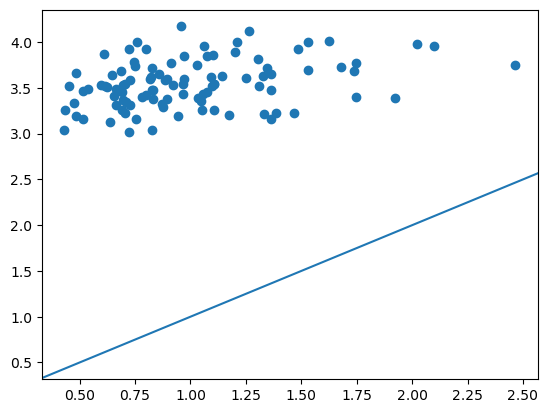

In [54]:
plt.scatter(get_y(batch).detach().cpu().numpy(), output.detach().cpu().numpy())
plt.axline((0.5,0.5), slope=1)

Now across all windows and tree sequences

In [55]:
import scipy.stats

In [56]:
# calculate r^2 of real and predictions
scipy.stats.pearsonr(real.flatten(), predictions.flatten())[0]**2

0.10035440808019261

In [57]:
sum(dict((p.data_ptr(), p.numel()) for p in model.parameters()).values())


361

Text(0.5, 0, 'Observed diversity')

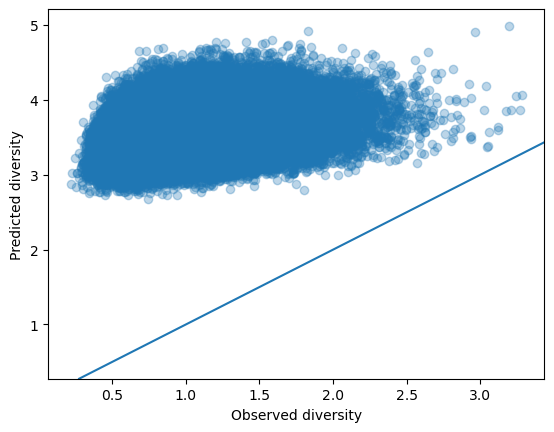

In [58]:


plt.scatter(real, predictions, alpha=0.3)
plt.axline((0.5,0.5), slope=1)

plt.ylabel('Predicted diversity')
plt.xlabel('Observed diversity')